# Demand Forecasting Using Exponential Smoothing

In this notebook, we develop reference models for demand forecasting and decomposition using exponential smoothing. The exponential smooting methods are commonly referred to as ETS which stands for Error, Trend, Seasonal.

See `_basic-components/time-series` folder for more time series models that can be applied to demand forecasting. Among the traditional time series models, exponential smooting and ARIMA are the two most common methods used in the demand forecasting practice. Both methods are particular cases of state space modeling (SSM). Among the modern demand forecasting methods, Bayesian structural time series (SSM) and sequence-to-sequence models such as RNNs and transformers are the most common choices.  

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import platform
print(f'Python {platform.python_version()}')

p = sns.color_palette()

Python 3.10.12


<ipython-input-4-2e770c54ab7d>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Data

We use a simple time series that is derived from the public Superstore Sales Data (see `datasets.md` for more details).
* The time series consists of montly sales numbers for one of the retail categories, 48 consecutive months in total.
* Each value is the average daily number of orders during the corresponding month.

In [ ]:
data = pd.read_csv('yahoo_stock.csv', parse_dates=['Date'], index_col='Date')
start_date = "2015-12-01"
end_date = "2020-11-20"
data_f = data['Close'][start_date:end_date]
# data_f.head()
data_s = data_f.resample('MS').mean()
data_s.head()

,Close
Date,
2015-12-01,2051.352913
2016-01-01,1927.887408
2016-02-01,1902.567938
2016-03-01,2023.688059
2016-04-01,2074.564001


# Simple Exponential Smoothing

We start with fitting the basic exponential smoothing model and producing the forecast.

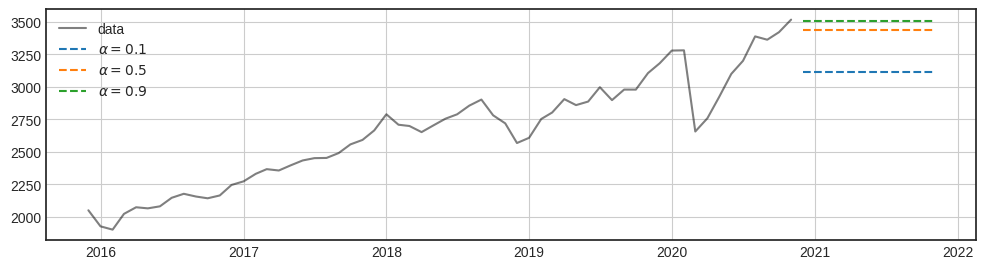

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(data_s, color='k', alpha=0.5)
alphas = [0.1, 0.5, 0.9]
for alpha in alphas:
    model = SimpleExpSmoothing(data_s, initialization_method="estimated").fit(smoothing_level=alpha)
    forecast = model.forecast(12)
    ax.plot(forecast, linestyle='--')
ax.legend(['data'] + [r"$\alpha=%s$" % a for a in alphas])
ax.grid(True)
plt.show()

# Double Exponetial Smoothing (Holt's Method)

Next, we fit the double exponential smoothing (Holt's) model.

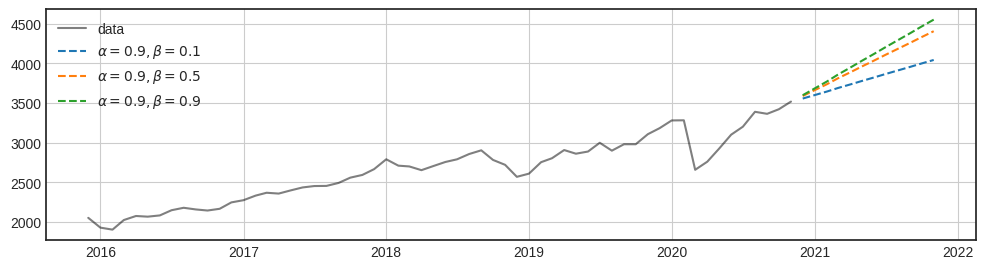

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(data_s, color='k', alpha=0.5)
alpha = 0.9
betas = [0.1, 0.5, 0.9]
for beta in betas:
    model = Holt(data_s, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta)
    forecast= model.forecast(12)
    ax.plot(forecast, linestyle='--')
ax.legend(['data'] + [r"$\alpha=%s, \beta=%s$" % (alpha, b) for b in betas])
ax.grid(True)

# Triple Exponential Smoothing (Holt-Winters' Method)

Next, we fit the triple exponential smoothing (Holt-Winters') model.

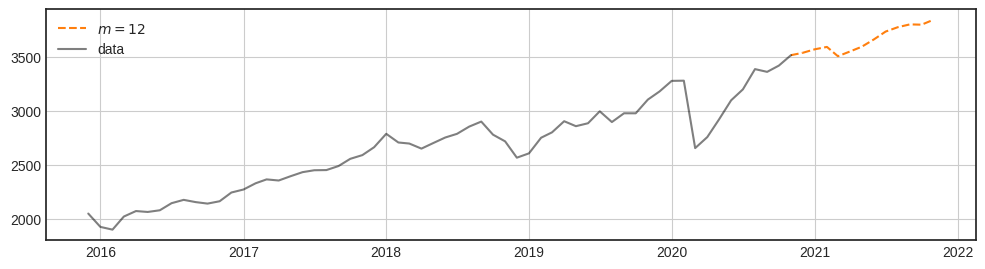

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
model = ExponentialSmoothing(data_s,
        seasonal_periods=12,
        trend="add",
        seasonal="add",
        use_boxcox=True).fit()
forecast= model.forecast(12)
ax.plot(pd.concat([data_s[-1:], forecast[:1]]), linestyle='--', color='C1')
ax.plot(data_s, color='k', alpha=0.5)
ax.plot(forecast, linestyle='--', color='C1')
ax.legend(['$m=12$', 'data'])
ax.grid(True)

# Probabilistic Forecast

The exponential smoothing models allows to estimate the variance of the forecast analytically. This estimate then can be used to draw the forecast samples from the distribution parametrized by the mean and variance. The confidence intervals and other statistics can be calculated based on the drawn samples.

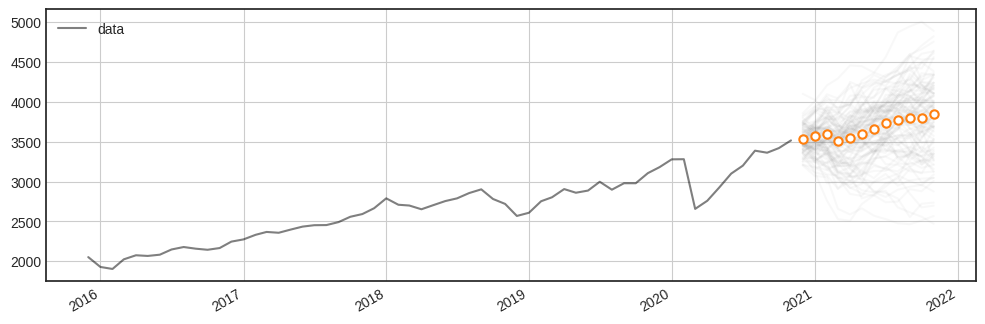

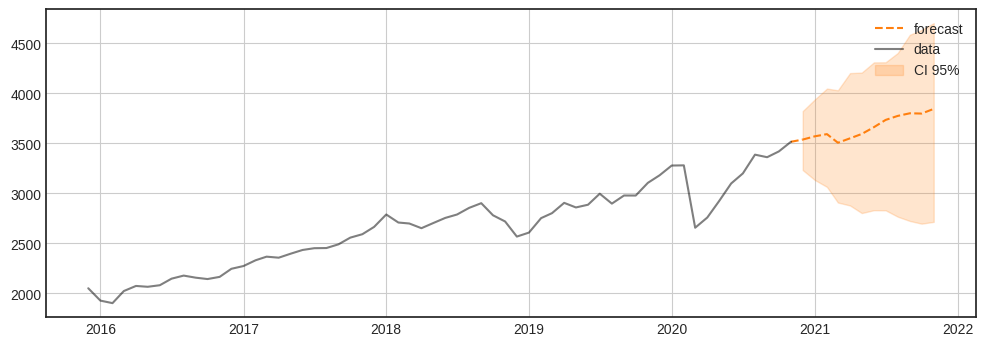

In [ ]:
model = ExponentialSmoothing(data_s,
        seasonal_periods=12,
        trend="add",
        seasonal="add",
        use_boxcox=True).fit()
forecast= model.forecast(12)
simulations = model.simulate(12, repetitions=100, error="add")

#
# Simulation
#
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(data_s, color='k', alpha=0.5)
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
ax.plot(forecast, marker='o', linestyle='None', markerfacecolor='white', markeredgewidth=1.5, color='C1')
ax.legend(['data'])
ax.grid(True)

#
# Confidence intervals
#
upper_ci = simulations.quantile(q=0.975, axis='columns')
lower_ci = simulations.quantile(q=0.025, axis='columns')
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(pd.concat([data_s[-1:], forecast[:1]]), linestyle='--', color='C1')
ax.plot(data_s, color='k', alpha=0.5)
ax.fill_between(forecast.index, lower_ci[-12:], upper_ci[-12:], alpha=0.2, color='C1')
ax.plot(forecast, linestyle='--', color='C1')
ax.legend(['forecast', 'data', 'CI 95%'])
ax.grid(True)

# Decomposition

The exponential smooting models represent the time series as a superposition of components with clear semantic meaning such as level, trend, and seasonality. These components can be visualized to provide insights into the structure of the series.

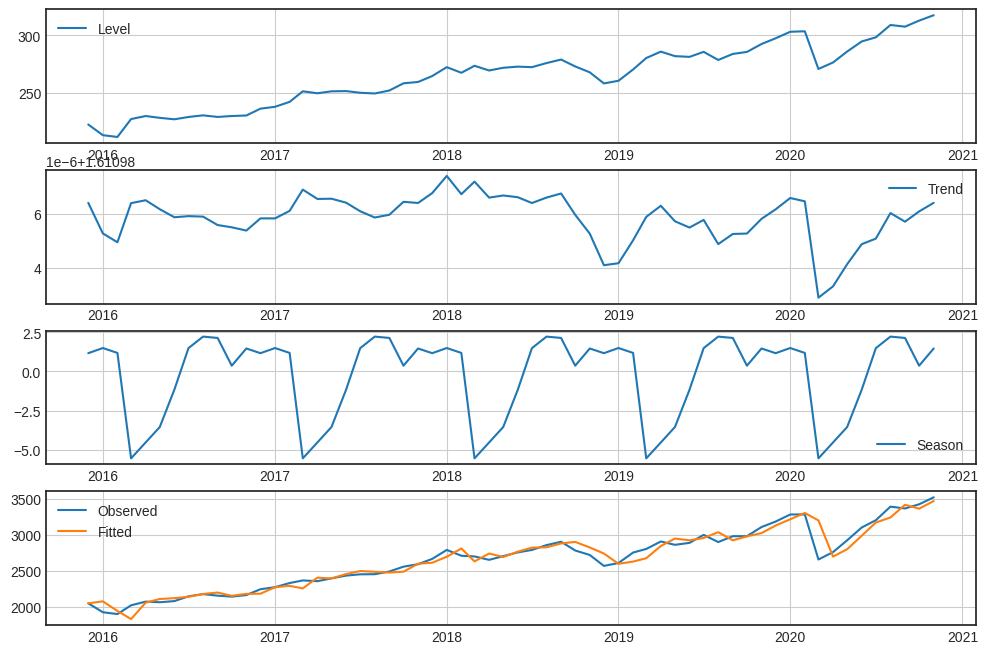

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(model.level, label='Level')
ax[1].plot(model.trend, label='Trend')
ax[2].plot(model.season, label='Season')
ax[3].plot(data_s, label='Observed')
ax[3].plot(model.fittedvalues, label='Fitted')
for i in range(len(ax)):
    ax[i].grid(True)
    ax[i].legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind, f_oneway
import os

In [ ]:
df = pd.read_csv('yahoo_stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
fig = px.line(df, x=df.index, y='Close', title='Closing Price Over Time')
fig.update_layout(title_text='Closing Price Over Time', title_x=0.5)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [ ]:
fig = make_subplots(rows=3, cols=2, subplot_titles=('Close', 'Volume', 'Open', 'High', 'Low', 'Adj Close'))
fig.add_trace(go.Histogram(x=df['Close'], name='Close'), row=1, col=1)
fig.add_trace(go.Histogram(x=df['Volume'], name='Volume'), row=1, col=2)
fig.add_trace(go.Histogram(x=df['Open'], name='Open'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['High'], name='High'), row=2, col=2)
fig.add_trace(go.Histogram(x=df['Low'], name='Low'), row=3, col=1)
fig.add_trace(go.Histogram(x=df['Adj Close'], name='Adj Close'), row=3, col=2)
fig.update_layout(title_text='Distribution of Features', title_x=0.5, template='plotly_dark')
fig.show()

In [ ]:
fig = px.scatter_matrix(df, dimensions=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], title='Scatter Matrix')
fig.update_layout(title_text='Scatter Matrix', title_x=0.5)
fig.show()

In [ ]:
t_stat, p_value = ttest_ind(df['High'], df['Low'])
t_test_result = {
    'Statistic': [t_stat],
    'p-value': [p_value]
}
t_test_df = pd.DataFrame(t_test_result)
t_test_df

,Statistic,p-value
0,2.070802,0.038447


In [ ]:
fig = px.bar(t_test_df, x=t_test_df.index, y=['Statistic', 'p-value'], barmode='group', title='T-test Result: High vs Low Prices')
fig.update_layout(title_text='T-test Result: High vs Low Prices', title_x=0.5)
fig.show()

In [ ]:
anova_stat, anova_p_value = f_oneway(df['Open'], df['High'], df['Low'], df['Close'])
anova_result = {
    'Statistic': [anova_stat],
    'p-value': [anova_p_value]
}
anova_df = pd.DataFrame(anova_result)
anova_df

,Statistic,p-value
0,1.432399,0.231203


In [ ]:
fig = px.bar(anova_df, x=anova_df.index, y=['Statistic', 'p-value'], barmode='group', title='ANOVA Test Result: Open, High, Low, Close Prices')
fig.update_layout(title_text='ANOVA Test Result: Open, High, Low, Close Prices', title_x=0.5)
fig.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [ ]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step
time_step = 60

In [ ]:
# Create training and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [ ]:
# Create dataset for LSTM
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
history = model.fit(X_train, y_train, batch_size=1, epochs=10)


Epoch 1/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 69s 45ms/step - loss: 0.0064
Epoch 2/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 0.0019
Epoch 3/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 0.0013
Epoch 4/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 0.0014
Epoch 5/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 84s 47ms/step - loss: 0.0011
Epoch 6/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - loss: 0.0011
Epoch 7/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 9.8382e-04
Epoch 8/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - loss: 0.0012
Epoch 9/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - loss: 0.0012
Epoch 10/10
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - loss: 0.0010


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Calculate RMSE and MAE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
train_mae = mean_absolute_error(y_train[0], train_predict[:, 0])
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}')
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}')

Train RMSE: 38.7035002105064, Train MAE: 32.41534009364949
Test RMSE: 95.88045134563238, Test MAE: 84.00390384071751


In [ ]:
# Plotting the results
train_data_len = len(train_data)

train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

In [ ]:
# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Actual Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=train_plot[:, 0], mode='lines', name='Train Predict', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=test_plot[:, 0], mode='lines', name='Test Predict', line=dict(color='red')))
fig.update_layout(title='Stock Price Prediction',
                   xaxis_title='Date',
                   yaxis_title='Stock Price')
fig.show()

In [ ]:
def predict_future(model, data, scaler, time_step=60, future_steps=30):
    # Prepare the input data for future prediction
    last_data = data[-time_step:]
    last_data = last_data.reshape(1, time_step, 1)

    # Predict future prices
    future_predictions = []
    for _ in range(future_steps):
        next_pred = model.predict(last_data)
        future_predictions.append(next_pred[0, 0])
        last_data = np.append(last_data[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)

    # Inverse transform the predictions to get actual values
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

# Example usage
future_steps = 30
future_predictions = predict_future(model, scaled_data, scaler, time_step, future_steps)

# Create future dates for plotting
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Plotting future predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Actual Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions[:, 0], mode='lines', name='Future Predict', line=dict(color='orange')))
fig.update_layout(title='Future Stock Price Prediction',
                   xaxis_title='Date',
                   yaxis_title='Stock Price')
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━